In [1]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import math
import glob
import numba
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm

from utils import set_plotting_style, get_chunking, get_chunking_dask
import utils

try:
    from yahist import Hist1D, Hist2D
except:
    !pip install git+git://github.com/aminnj/yahist.git#egg=yahist -U
    from yahist import Hist1D, Hist2D

import concurrent.futures

import scipy.stats
from dask.distributed import Client
import dask.dataframe as dd
from dask import delayed
import utils

In [2]:
set_plotting_style()

## Make dataframes

In [88]:
executor = concurrent.futures.ProcessPoolExecutor(8)

def make_df(fname,entrystart=None,entrystop=None,bigrho=True):
    t = uproot.open(fname)["Events"]
    arrs = t.arrays(["n*","pass_*",
                     "MET_*",
                     "/(PVM|BS)_(x|y|z)$/",
                     "/Jet_(pt|eta|phi|m)$/",
                     "/Muon_(pt|eta|phi|m|n.*|trackIso|charge|trk_qoverp.*|trk_.*|dz.*|dxy.*|chi2|ndof|vx|vy|vz|vtxIdx.*|jetIdx.*|good|drjet)$/",
                     "/DV_(tracksSize|chi2|ndof|rho.*|inPixel.*|x|y|z|xError|yError|zError|good)$/",
                     "run","luminosityBlock","event",
                     "L1_DoubleMu4p5_SQ_OS_dR_Max1p2",
                     "L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4",
                     "L1_DoubleMu_15_7",
                    ],outputtype=dict,namedecode="ascii",entrystart=entrystart,entrystop=entrystop)
    
    # booleans for selection
    sel = (
        (arrs["nDV"] == 1) 
        & (arrs["nMuon"] == 2) 
        & arrs["pass_l1"] 
        & arrs["pass_skim"] 
        & arrs["pass_fiducialgen"]
    )
    if bigrho:
        sel = sel & (arrs["DV_rho"]>1.0).any()

    # flatten into dataframe and require `sel`
    df = pd.DataFrame()
    for k in arrs.keys():
        if any(k.startswith(y) for y in ["n","pass_","BS_","MET_","run","lumi","event","L1_"]):
            df[k] = arrs[k][sel]
        if k.startswith("DV_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("PVM_"):
            df[k] = arrs[k][sel][:,0]
        if k.startswith("Muon_"):
            df[k.replace("Muon_","Muon1_")] = arrs[k][sel][:,0]
            df[k.replace("Muon_","Muon2_")] = arrs[k][sel][:,1]
        if k.startswith("Jet_"):
            # make sure there is at least 1 jet per event, filled with 0s
            padded = arrs[k][sel].pad(1).fillna(0.)
            # convert index of -1 (no jet found) to at least 0, and then we will pick up the 
            # dummy 0s from the padded array
            vals = padded[np.maximum(arrs["Muon_jetIdx1"][sel],0)]
            df[k.replace("Jet_","Muon1_Jet_")] = vals[:,0]
            df[k.replace("Jet_","Muon2_Jet_")] = vals[:,1]

    # augment
    TLVA = uproot_methods.TLorentzVectorArray
    TV2A = uproot_methods.TVector2Array
    TV3A = uproot_methods.TVector3Array
    mu1 = TLVA.from_ptetaphim(df["Muon1_pt"],df["Muon1_eta"],df["Muon1_phi"],0.10566)
    mu2 = TLVA.from_ptetaphim(df["Muon2_pt"],df["Muon2_eta"],df["Muon2_phi"],0.10566)
    jetmu1 = TLVA.from_ptetaphim(df["Muon1_Jet_pt"],df["Muon1_Jet_eta"],df["Muon1_Jet_phi"],df["Muon1_Jet_m"])
    jetmu2 = TLVA.from_ptetaphim(df["Muon2_Jet_pt"],df["Muon2_Jet_eta"],df["Muon2_Jet_phi"],df["Muon2_Jet_m"])
    dimu = mu1+mu2
    df["dimuon_mass"] = dimu.mass
    df["dimuon_eta"] = dimu.eta
    df["dimuon_phi"] = dimu.phi
    df["dimuon_pt"] = dimu.pt
    
    df["dimuon_deltaeta"] = np.abs(mu1.eta - mu2.eta)
    df["dimuon_deltar"] = mu1.delta_r(mu2)
    
    jets = TLVA.from_ptetaphim(arrs["Jet_pt"][sel],arrs["Jet_eta"][sel],arrs["Jet_phi"][sel],arrs["Jet_m"][sel])
    mindrs = dimu.delta_r(jets).min()
    mindrs[~np.isfinite(mindrs)] = 0.
    df["dimuon_drjet"] = mindrs
    
    vecdimu = TV2A.from_polar(dimu.pt,dimu.phi)
    vecdv2d = TV2A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"])
    vecdv3d = TV3A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"],df["DV_z"]-df["BS_z"])
    df["absdphimudv"] = np.abs(vecdimu.delta_phi(vecdv2d))
    df["absdphimumu"] = np.abs(mu1.delta_phi(mu2))
    df["cosphi"] = vecdimu.cosdelta(vecdv2d)
    df["angle3dmumu"] = np.arccos(mu1.p3.dot(mu2.p3)/(mu1.p3.mag*mu2.p3.mag))
    df["angle3dmudv"] = np.arccos(dimu.p3.dot(vecdv3d)/(dimu.p3.mag*vecdv3d.mag))
    df["DV_chi2prob"] = 1.0-scipy.stats.chi2.cdf(df["DV_chi2"],df["DV_ndof"])
    df["DV_redchi2"] = df["DV_chi2"]/df["DV_ndof"]
    df["DV_xyErrorMax"] = np.maximum(df["DV_xError"],df["DV_yError"])
    df["Muon1_redchi2"] = df["Muon1_chi2"]/df["Muon1_ndof"]
    df["Muon2_redchi2"] = df["Muon2_chi2"]/df["Muon2_ndof"]
    df["Muon1_adqpt"] = np.abs(df["Muon1_trk_qoverpError"]/df["Muon1_trk_qoverp"])
    df["Muon2_adqpt"] = np.abs(df["Muon2_trk_qoverpError"]/df["Muon2_trk_qoverp"])
    df["Muon1_m"] = 0.10566
    df["Muon2_m"] = 0.10566
    
    vecmetcorr = TV2A.from_polar(df["MET_pt_muonCorr"],df["MET_phi_muonCorr"])
    vecmet = TV2A.from_polar(df["MET_pt"],df["MET_phi"])
    df["Muon1_dphimetcorr"] = mu1.delta_phi(vecmetcorr)
    df["Muon2_dphimetcorr"] = mu2.delta_phi(vecmetcorr)
    df["dimuon_dphimetcorr"] = dimu.delta_phi(vecmetcorr)
    df["Muon1_dphimet"] = mu1.delta_phi(vecmet)
    df["Muon2_dphimet"] = mu2.delta_phi(vecmet)
    df["dimuon_dphimet"] = dimu.delta_phi(vecmet)
    
    df["maxabsdxy"] = np.maximum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["minabsdxy"] = np.minimum(np.abs(df["Muon1_dxyCorr"]),np.abs(df["Muon2_dxyCorr"]))
    df["maxdxy"] = np.maximum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    df["mindxy"] = np.minimum(df["Muon1_dxyCorr"],df["Muon2_dxyCorr"])
    
    df["logabsetaphi"] = df.eval("log10(abs(Muon1_eta-Muon2_eta)/(Muon1_phi-Muon2_phi))")
    
#     testvecdv3d = TV3A.from_cartesian(df["DV_x"]-df["BS_x"],df["DV_y"]-df["BS_y"],df["DV_z"]-1.0*df["BS_z"])
#     dveta = np.arcsinh(testvecdv3d.z / np.hypot(testvecdv3d.x**2,testvecdv3d.y**2))
#     df["dimuon_detadv"] = dimu.eta-dveta
    
    # category 1: any L1s, dR(mumu)<1.2
    # category 2: at least the L1_15_7 bit, dR(mumu)>1.2, and pT>15/7
    df["categ"] = df.eval("   1*(dimuon_deltar<1.2) "
                          " + 2*(dimuon_deltar>1.2 and L1_DoubleMu_15_7 and Muon1_pt>15 and Muon2_pt>7)").astype(int)
    
    # skim more
    # split into two queries since numexpr errors for large number of inputs
    df = df.query(
        # DV selections
        " (dimuon_mass > 0.0)"
        " and (DV_xError < 0.05)"
        " and (DV_yError < 0.05)"
        " and (DV_zError < 0.10)"
        " and (DV_rhoCorr < 11)"
        " and (DV_redchi2 < 5)"
        # angles
        " and (cosphi > 0.)"
        " and (absdphimumu < 2.8)"
        " and (absdphimudv < 0.02)"
    ).query(
        # muon quality
        "     (Muon1_charge != Muon2_charge)"
        " and (Muon1_nValidMuonHits > 0) and (Muon2_nValidMuonHits > 0)"
        " and (Muon1_redchi2 < 3) and (Muon2_redchi2 < 3)"
        # muon isolation
        " and (Muon1_trackIso < 0.1) and (Muon2_trackIso < 0.1)"
        " and ((Muon1_drjet > 0.3) or (Muon1_drjet < 0))"
        " and ((Muon2_drjet > 0.3) or (Muon2_drjet < 0))"
    )
    return df
    
fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v7//output_1.root")
futures_mc = executor.map(make_df, fnames_mc)
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7skim1cmjets/*.root")
futures_data = executor.map(make_df, fnames_data)
df_data = pd.concat(tqdm(futures_data,total=len(fnames_data))).reset_index(drop=True)
df_mc = pd.concat(tqdm(futures_mc,total=len(fnames_mc))).reset_index(drop=True)

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in arccos
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/uproot_methods/classes/TLorentzVector.py:189: RuntimeWarning: invalid value encountered in sqrt
  return self._trymemo("mass", lambda self: self.awkward.numpy.sqrt(self.mag2))
/home/users/namin/miniconda3/envs/analysisen

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in arccos


Process ForkProcess-149:
Process ForkProcess-148:
Process ForkProcess-151:
Process ForkProcess-146:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/users/namin/miniconda3/envs/analysisenv/lib

Text(0.5, 1.0, '$\\Delta\\eta$(dimuon,DV)')

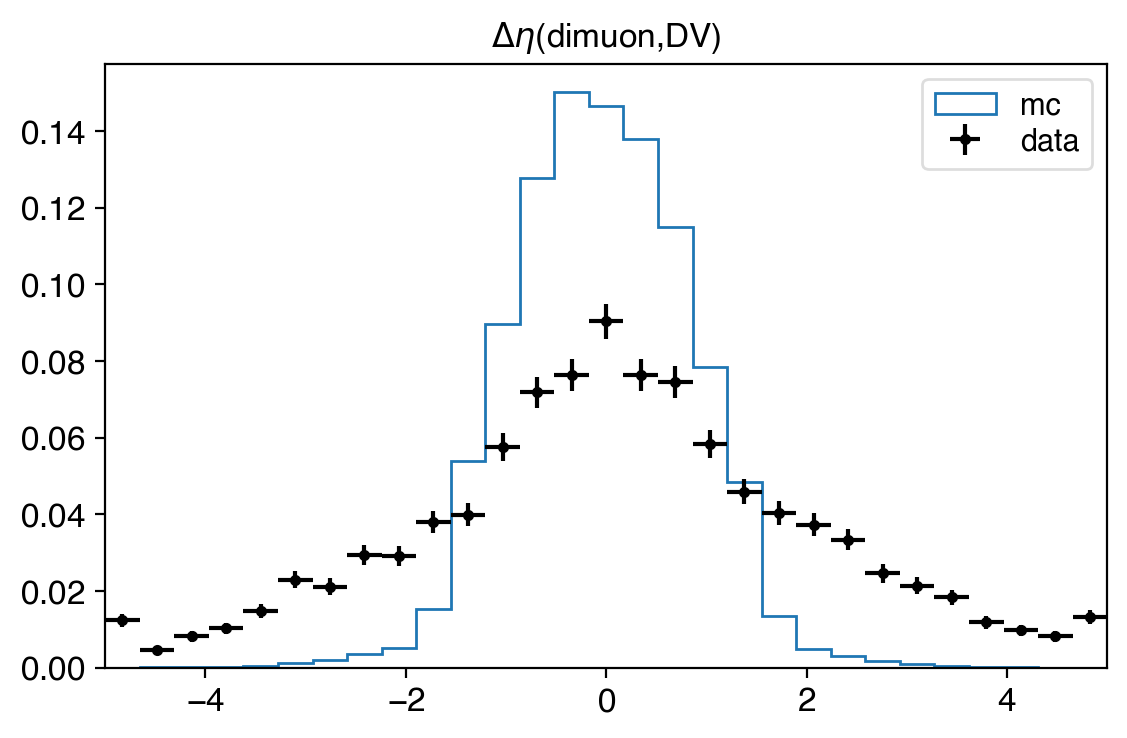

In [87]:
fig, ax = plt.subplots()
bins = np.linspace(-5,5,30)
df_mc.tree.draw("dimuon_detadv","dimuon_mass>5",bins=bins).normalize().plot(ax=ax,label="mc",histtype="step")
df_data.tree.draw("dimuon_detadv","dimuon_mass>5",bins=bins).normalize().plot(ax=ax,label="data",show_errors=True,color="k",ms=3)
ax.legend()
ax.set_title(r"$\Delta\eta$(dimuon,DV)")

In [29]:
print(df_data.shape)
print(df_mc.shape)

(36583, 155)
(56753, 155)


In [89]:
if True:
# if False:
    df_data.to_pickle("data/df_data.pkl")
    df_mc.to_pickle("data/df_mc.pkl")
else:
    df_data = pd.read_pickle("data/df_data.pkl")
    df_mc = pd.read_pickle("data/df_mc.pkl")

In [90]:
df_mc.head()

,nDV,nDV_good,nJet,nPV,nPVM,nMuon,nMuon_good,nGenPart,nGenMuon,pass_skim,...,dimuon_dphimetcorr,Muon1_dphimet,Muon2_dphimet,dimuon_dphimet,maxabsdxy,minabsdxy,maxdxy,mindxy,logabsetaphi,categ
0,1,1,3,13,4,2,2,9,2,True,...,-2.095440,-0.114034,-0.938059,-0.276297,2.004623,0.543271,2.004623,-0.543271,-0.472144,1
1,1,1,0,8,2,2,2,10,2,True,...,-3.008773,-2.888981,-2.095557,-2.730076,1.116448,0.307861,0.307861,-1.116448,NaN,0
2,1,1,2,10,2,2,2,10,2,True,...,-2.718939,-2.085387,-2.292743,-2.163227,1.248943,0.704636,1.248943,-0.704636,0.656495,1
3,1,1,0,12,2,2,2,13,2,True,...,-2.592965,-0.887737,-1.501589,-1.161710,1.807147,1.482357,1.807147,-1.482357,NaN,1
4,1,1,1,2,1,2,2,11,2,True,...,-1.438546,-0.587361,0.859148,-0.429744,8.295023,1.362153,1.362153,-8.295023,NaN,0


## Plot dump

In [91]:
nevents = uproot.numentries("/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd20_ctau50mm_BABY_v7//output_1.root","Events")
print(nevents)
xsec = 1e3 # fb
lumi = 1.0 # ifb
sigweight = lumi * xsec / nevents
sigweight

497000


0.002012072434607646

In [92]:
# plotdir = "plots_split_v4/"
plotdir = "plots_scouting_massgt5_iso"
os.system("mkdir -p {}".format(plotdir))

globalsel = "dimuon_mass>5"
normalize = True

selinfos = []

selinfos.append(dict(vsels=[
    ["all",lambda df: slice(None)],
],split_label = "splitnone"))

selinfos.append(dict(vsels=[
    [r"dimuon $\eta$<0.9",lambda df:  np.abs(df["dimuon_eta"])<0.9],
    [r"dimuon $\eta$>0.9",lambda df: np.abs(df["dimuon_eta"])>0.9],
],split_label = "spliteta"))

selinfos.append(dict(vsels=[
    [r"DV $\rho$ 1-3cm",lambda df:  (np.abs(df["DV_rhoCorr"])<3.0) & (np.abs(df["DV_rhoCorr"])>1.0)],
    [r"DV $\rho$ 3-11cm",lambda df:  (np.abs(df["DV_rhoCorr"])<11.0) & (np.abs(df["DV_rhoCorr"])>3.0)],
],split_label = "splitrho"))

selinfos.append(dict(vsels=[
    ["5<mass<15",lambda df:  (df["dimuon_mass"]<15) & (df["dimuon_mass"]>5)],
    ["mass>15",lambda df:  (df["dimuon_mass"]>15)],
],split_label = "splitmass"))

selinfos.append(dict(vsels=[
    ["categ==0",lambda df:  (df["categ"]==0)],
    ["categ==1",lambda df:  (df["categ"]==1)],
    ["categ==2",lambda df:  (df["categ"]==2)],
],split_label = "splitcateg"))

plotinfos = [
    
    [[lambda df: df["Muon1_nValidPixelHits"],lambda df: df["Muon2_nValidPixelHits"]], np.arange(10)-0.5, dict(title="Muon nValidPixelHits",shortname="nValidPixelHits")],
    [[lambda df: df["Muon1_nValidStripHits"],lambda df: df["Muon2_nValidStripHits"]], np.arange(30)-0.5, dict(title="Muon nValidStripHits",shortname="nValidStripHits")],
    
    
    [[lambda df: df["Muon1_nExpectedPixelHits"],lambda df: df["Muon2_nExpectedPixelHits"]], np.arange(12)-0.5, dict(title="Muon nExpectedPixelHits",shortname="nExpectedPixelHits")],
    [[lambda df: df.eval("Muon1_nValidPixelHits-Muon1_nExpectedPixelHits"),lambda df: df.eval("Muon2_nValidPixelHits-Muon2_nExpectedPixelHits")], np.arange(10)-5.5, dict(title="Muon n(Valid-Expected)PixelHits",shortname="nValidMinusExpectedPixelHits")],
    
    [[lambda df: df["Muon1_nTrackerLayersWithMeasurement"],lambda df: df["Muon2_nTrackerLayersWithMeasurement"]], np.arange(20)-0.5, dict(title="Muon nTrackerLayersWithMeasurement",shortname="nTrackerLayers")],
    [[lambda df: df["Muon1_nMatchedStations"],lambda df: df["Muon2_nMatchedStations"]], np.arange(7)-0.5, dict(title="Muon nMatchedStations",shortname="nMatchedStations")],
    [[lambda df: df["Muon1_nValidMuonHits"],lambda df: df["Muon2_nValidMuonHits"]], np.arange(60)-0.5, dict(title="Muon nValidMuonHits",shortname="nValidMuonHits")],
    
    [[lambda df: df["Muon1_eta"],lambda df: df["Muon2_eta"]], np.linspace(-2.5,2.5,50), dict(title="Muon eta",shortname="eta")],
    [[lambda df: df["Muon1_phi"],lambda df: df["Muon2_phi"]], np.linspace(-3.2,3.2,50), dict(title="Muon phi",shortname="phi")],
    [[lambda df: df["Muon1_pt"],lambda df: df["Muon2_pt"]], np.linspace(0,100,50), dict(title="Muon pT",shortname="pt")],
    [[lambda df: np.abs(df["Muon1_dxyCorr"]),lambda df: np.abs(df["Muon2_dxyCorr"])], np.linspace(0.0,6,150), dict(title="abs(Muon dxy)",logy=True,logx=True,shortname="absdxy")],
    [[lambda df: df["Muon1_dxyCorr"],lambda df: df["Muon2_dxyCorr"]], np.linspace(-5,5,150), dict(title="(signed) Muon dxy",logy=True,shortname="signeddxy")],
    [[lambda df: df["maxdxy"]], np.linspace(-6,6,150), dict(title="max(Muon1 dxy, Muon2 dxy)",logy=True,shortname="maxdxy")],
    [[lambda df: df["mindxy"]], np.linspace(-6,6,150), dict(title="min(Muon1 dxy, Muon2 dxy)",logy=True,shortname="mindxy")],
    [[lambda df: df["maxabsdxy"]], np.linspace(-6,6,150), dict(title="max(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="maxabsdxy")],
    [[lambda df: df["minabsdxy"]], np.linspace(-6,6,150), dict(title="min(abs(Muon1 dxy), abs(Muon2 dxy))",logy=True,shortname="minabsdxy")],
    [[lambda df: df["Muon1_dxyError"],lambda df: df["Muon2_dxyError"]], np.linspace(0.001,0.02,150), dict(title="Muon dxy Error",logy=True,shortname="dxyError")],
    
    [[lambda df: df["Muon1_redchi2"],lambda df: df["Muon2_redchi2"]], np.linspace(0,5,100), dict(title="Muon chi2/ndof",shortname="Muonchi2")],
    [[lambda df: df["Muon1_adqpt"],lambda df: df["Muon2_adqpt"]], np.linspace(0,0.05,100), dict(title="Muon abs(qoverpError/qoverp)",shortname="relqoverp")],
    [[lambda df: df["Muon1_trackIso"],lambda df: df["Muon2_trackIso"]], np.linspace(0,0.1,50), dict(title="Muon trackIso",logy=True,shortname="trackIso")],
    [[lambda df: df["Muon1_drjet"],lambda df: df["Muon2_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(muon,closest jet)",shortname="drjet")],
    
    [[lambda df: df["DV_inPixelRectangles"]], np.linspace(-0.5,1.5,3), dict(title="Is in pixel rectangle?",shortname="inPixel")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho (logscale)",logy=True,shortname="rholog")],
    [[lambda df: df["DV_rhoCorr"]], np.linspace(0.1,12,100), dict(title="DV rho",logy=False,shortname="rho")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2))",shortname="dphimumu")],
    [[lambda df: df["absdphimumu"]], np.linspace(0,2.0,150), dict(title="abs(dphi(mu1,mu2)), logscale",logx=True,logy=True,shortname="dphimumulog")],
    [[lambda df: df["absdphimudv"]], np.linspace(0,0.03,50), dict(title="abs(dphi(dimuon,DV))",shortname="dphimudv")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,80), dict(title="Dimuon mass",logy=False,logx=False,shortname="mass")],
    [[lambda df: df["dimuon_mass"]], np.linspace(5,40,36), dict(title="Dimuon mass (logscale)",logy=True,logx=False,shortname="masslog")],
    [[lambda df: df["dimuon_pt"]], np.linspace(0,100,200), dict(title="Dimuon pT",shortname="dimuonpt")],
    [[lambda df: df["dimuon_drjet"]], np.linspace(0,2*np.pi,100), dict(title="dR(dimuon,closest jet)",shortname="dimudrjet")],
    
    [[lambda df: df["MET_pt_muonCorr"]], np.linspace(0,150,25), dict(title="caloMET pt (muon corrected)",shortname="metpt")],
    [[lambda df: df["MET_phi_muonCorr"]], np.linspace(-3.2,3.2,25), dict(title="caloMET phi (muon corrected)",shortname="metphi")],
    [[lambda df: df["dimuon_dphimetcorr"]], np.linspace(-3.2,3.2,25), dict(title="$\Delta\phi$(dimuon,corrected-MET)",shortname="dphimetcorr")],
    [[lambda df: df["dimuon_dphimet"]], np.linspace(-3.2,3.2,25), dict(title="$\Delta\phi$(dimuon,raw-MET)",shortname="dphimet")],
    
    [[lambda df: df["DV_zError"]], np.linspace(0.0,0.1,50), dict(title="DV zError",shortname="zError")],
    [[lambda df: df["DV_xyErrorMax"]], np.linspace(0.0,0.05,50), dict(title="DV max(xError,yError)",shortname="xyErrorMax")],
    [[lambda df: df["DV_redchi2"]], np.linspace(0.0,10.0,100), dict(title="DV chi2/ndof",shortname="DVchi2")],
    [[lambda df: df["DV_chi2prob"]], np.linspace(0.0,1.0,100), dict(title="DV chi2 prob",shortname="DVchi2prob")],
    [[lambda df: np.log10(df["DV_redchi2"])], np.linspace(-5,1.5,100), dict(title="DV log10(chi2/ndof)",shortname="DVlogchi2")],
    
    [[lambda df: df["nPV"]], np.arange(40)-0.5, dict(title="nPV (from hltPixelVertices)",shortname="nPV")],
    [[lambda df: df["nPVM"]], np.arange(15)-0.5, dict(title="nPVM (from hltPixelVerticesL3MuonNoVtx)",shortname="nPVM")],
    [[lambda df: df["nJet"]], np.arange(15)-0.5, dict(title="nJet",shortname="njets")],
    
    [[lambda df: df["angle3dmumu"]], np.linspace(0,3.142,50), dict(title="3d angle between mu1 and mu2",shortname="angle3dmumu")],
    [[lambda df: df["angle3dmudv"]], np.linspace(0,3.142,50), dict(title="3d angle between dimuon and DV",shortname="angle3dmudv")],
    
    [[lambda df: df["dimuon_deltar"]], np.linspace(0,5,50), dict(title="$\Delta$R(mu1,mu2)",shortname="drmumu")],
    [[lambda df: df["dimuon_deltaeta"]], np.linspace(0,5,50), dict(title="$\Delta\eta$(mu1,mu2)",shortname="detamumu")],
    
    [[lambda df: df["logabsetaphi"]], np.linspace(-10,10,50), dict(title="ln(abs($\Delta\eta_{12}/\Delta\phi_{12}$))",shortname="logabsetaphi")],
    [[lambda df: df["categ"]], np.linspace(-0.5,2.5,4), dict(title="category (1=any,dR<1.2; 2=L1_15_7,dR>1.2)",shortname="category")],
    
]

# plotinfos = [
# ]

for selinfo in selinfos:
    vsels = selinfo["vsels"]
    split_label = selinfo["split_label"]
    
    for fs,bins,opts in plotinfos:
        fig,ax = plt.subplots()

        ymax = 0.
        datanorms = {}
        for df,label,linestyle in [
            [df_data,"Data","-"],
            [df_mc,"Signal","-"],
        ]:
            

            for (sel_label,fsel),color in zip(vsels,["C0","C3","C2","C1"]):
                
                # skip low stats MC splits
                if (label == "Signal") and (("mass<5" in sel_label) or ("mass<15" in sel_label)): continue
                    
                if globalsel:
                    df = df.query(globalsel)
                sel = fsel(df)
                h = sum([Hist1D(f(df)[sel],bins=bins) for f in fs])
                if normalize:
                    h = h.normalize()
                else:
                    if "signal" in label.lower():
                        h *= (datanorms[sel_label]/h.counts.sum())
                        label = r"Signal (norm. to data)"
#                         h *= sigweight
#                         label = r"Signal ($\sigma$={:g}pb)".format(xsec/1000)
                if label == "Data":
                    datanorms[sel_label] = h.counts.sum()
#                     h.plot(ax=ax,label="{} ({})".format(label,sel_label),color="k",show_errors=True,markersize=2.5);
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,show_errors=True,markersize=2.5);
                else:
                    h.plot(ax=ax,label="{} ({})".format(label,sel_label),color=color,histtype="step",linestyle=linestyle);
                ax.text(0.99, 1.01,"2018C, 1 fb${}^\mathregular{-1}$", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="large")
                ymax = max(ymax,h.counts.max())

        if opts.get("logx"):
            ax.set_xscale("log")

        if opts.get("logy"):
            ax.set_ylim(0.00001,ymax*1.5)
            ax.set_yscale("log")
        else:
            ax.set_ylim(ax.get_ylim()[0],ymax*1.2)

        ax.set_xlabel(opts.get("xlabel",""),horizontalalignment="right",x=1.)
        ylabel = "Frac. of events" if normalize else "Events"
        ax.set_ylabel(opts.get("ylabel",ylabel),horizontalalignment="right",y=1.)
        ax.set_title(opts.get("title",""))
        
        ax.legend()
        
        shortname = opts.get("shortname","unknown")
        fname = "{}/{}_{}.png".format(plotdir,split_label,shortname)
        print(fname)
#     break
        fig.set_tight_layout(True)
        fig.savefig(fname,dpi=150)
        
        # Don't show the figure in the notebook
        plt.close()
#         break

plots_scouting_massgt5_iso/splitnone_nValidPixelHits.png
plots_scouting_massgt5_iso/splitnone_nValidStripHits.png
plots_scouting_massgt5_iso/splitnone_nExpectedPixelHits.png
plots_scouting_massgt5_iso/splitnone_nValidMinusExpectedPixelHits.png
plots_scouting_massgt5_iso/splitnone_nTrackerLayers.png
plots_scouting_massgt5_iso/splitnone_nMatchedStations.png
plots_scouting_massgt5_iso/splitnone_nValidMuonHits.png
plots_scouting_massgt5_iso/splitnone_eta.png
plots_scouting_massgt5_iso/splitnone_phi.png
plots_scouting_massgt5_iso/splitnone_pt.png
plots_scouting_massgt5_iso/splitnone_absdxy.png
plots_scouting_massgt5_iso/splitnone_signeddxy.png
plots_scouting_massgt5_iso/splitnone_maxdxy.png
plots_scouting_massgt5_iso/splitnone_mindxy.png
plots_scouting_massgt5_iso/splitnone_maxabsdxy.png
plots_scouting_massgt5_iso/splitnone_minabsdxy.png
plots_scouting_massgt5_iso/splitnone_dxyError.png
plots_scouting_massgt5_iso/splitnone_Muonchi2.png
plots_scouting_massgt5_iso/splitnone_relqoverp.png
plot

plots_scouting_massgt5_iso/splitmass_Muonchi2.png
plots_scouting_massgt5_iso/splitmass_relqoverp.png
plots_scouting_massgt5_iso/splitmass_trackIso.png
plots_scouting_massgt5_iso/splitmass_drjet.png
plots_scouting_massgt5_iso/splitmass_inPixel.png
plots_scouting_massgt5_iso/splitmass_rholog.png
plots_scouting_massgt5_iso/splitmass_rho.png
plots_scouting_massgt5_iso/splitmass_dphimumu.png
plots_scouting_massgt5_iso/splitmass_dphimumulog.png
plots_scouting_massgt5_iso/splitmass_dphimudv.png
plots_scouting_massgt5_iso/splitmass_mass.png
plots_scouting_massgt5_iso/splitmass_masslog.png
plots_scouting_massgt5_iso/splitmass_dimuonpt.png
plots_scouting_massgt5_iso/splitmass_dimudrjet.png
plots_scouting_massgt5_iso/splitmass_metpt.png
plots_scouting_massgt5_iso/splitmass_metphi.png
plots_scouting_massgt5_iso/splitmass_dphimetcorr.png
plots_scouting_massgt5_iso/splitmass_dphimet.png
plots_scouting_massgt5_iso/splitmass_zError.png
plots_scouting_massgt5_iso/splitmass_xyErrorMax.png
plots_scouting

In [93]:

with open("{}/description.txt".format(plotdir),"w") as fh:
    fh.write("""
Selection: 
<ul>
<li>==2 OS muons, ==1 DV</li>
<li>1cm < DV rho < 11cm</li>
<li>cos(dphi(dimuon,DV))>0</li>
<li>max(DV_xError,yError)<0.05cm, DV_zError<0.1cm</li>
<li>valid muon hits>0 for each muon</li>
<li>|dphi(mu1,mu2)|<2.8</li>
<li>|dphi(dimuon,DV)| < 0.02</li>
<li>Muon trackIso < 0.1 for each muon</li>
<li>dR(muon,closest jet) > 0.3 for each muon</li>
<li>Muon chi2/ndof < 3</li>
<li>DV chi2/ndof < 5</li>
</ul>
Split plots by:
<ul>
<li>nothing ("splitnone_")</li>
<li>DV rho ("splitrho_")</li>
<li>eta of dimuon system ("spliteta_")</li>
<li>mass of dimuon system ("splitmass_")</li>
<li>category ("splitcateg_")</li>
</ul>
    """)

!niceplots {plotdir}

Not converting anything
ln: creating symbolic link `plots_scouting_massgt5_iso/index.php': File exists
uaf-10.t2.ucsd.edu/~namin/dump/plots/plots_scouting_massgt5_iso/


In [338]:
client = Client("uaf-10.t2.ucsd.edu:50123")
client.restart()
client

Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 32 Cores: 32 Memory: 160.00 GB


In [135]:
delayed_make_df = delayed(make_df)

In [213]:
fnames_data = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7jets/*.root")
chunks, total_events = utils.get_chunking_dask(tuple(fnames_data),200e3,client=client)
len(chunks)

314

In [214]:
meta = make_df(chunks[0][0],0,1000,bigrho=False)
df = (dd
      .from_delayed((delayed_make_df(*chunk,bigrho=False) for chunk in chunks),meta=meta)
      .persist()
 )

from dask.distributed import progress
progress(df)

VBox()

In [217]:
print(len(df))
print((df.memory_usage().sum()/1e6).compute())
localdf = df.compute()
localdf.to_pickle("data/df_data_allrho.pkl")

1163137
733.939447


In [108]:
chunks, total_events = utils.get_chunking_dask(tuple(fnames_mc),500e3,client=client)
print(len(chunks))
(dd.from_delayed((delayed_make_df(*chunk,bigrho=False) for chunk in chunks),meta=meta)
 .compute()
 .to_pickle("data/df_mc_allrho.pkl")
)

1


In [65]:
df.head()

,nDV,nDV_good,nJet,nPV,nPVM,nMuon,nMuon_good,nGenPart,nGenMuon,pass_skim,...,dimuon_dphimetcorr,Muon1_dphimet,Muon2_dphimet,dimuon_dphimet,maxabsdxy,minabsdxy,maxdxy,mindxy,logabsetaphi,categ
20,1,1,2,0,8,2,2,0,0,True,...,2.178752,2.070965,1.197224,1.639344,0.118653,0.115305,0.115305,-0.118653,-0.771512,1
88,1,1,1,0,5,2,2,0,0,True,...,-1.899984,-1.741855,-1.596789,-1.679702,0.032491,0.031100,0.032491,-0.031100,NaN,1
129,1,1,1,0,13,2,2,0,0,True,...,-0.877258,-0.801726,-0.405971,-0.648278,0.101605,0.055473,0.055473,-0.101605,NaN,1
146,1,1,0,0,4,2,2,0,0,True,...,-1.958107,-1.799673,-1.579166,-1.697579,0.055235,0.050056,0.050056,-0.055235,NaN,1
237,1,1,0,0,11,2,2,0,0,True,...,-0.844105,-0.345409,-0.408251,-0.368802,0.017988,0.002759,0.017988,-0.002759,1.594657,1


In [69]:
# len(df)
uproot.numentries("/hadoop/cms/store/user/namin/ProjectMetis/ScoutingCaloMuon_Run2018skim_2018C_v4_unblind1fb_RAW_v7jets/*.root","Events")/1e6


61.75905

In [109]:
!ssh uafino.physics.ucsb.edu ./syncdataframes.sh

In [115]:
dir(df)

['BS_x',
 'BS_y',
 'BS_z',
 'DV_chi2',
 'DV_chi2prob',
 'DV_good',
 'DV_inPixelRectangles',
 'DV_ndof',
 'DV_redchi2',
 'DV_rho',
 'DV_rhoCorr',
 'DV_tracksSize',
 'DV_x',
 'DV_xError',
 'DV_xyErrorMax',
 'DV_y',
 'DV_yError',
 'DV_z',
 'DV_zError',
 'L1_DoubleMu0er1p4_SQ_OS_dR_Max1p4',
 'L1_DoubleMu4p5_SQ_OS_dR_Max1p2',
 'L1_DoubleMu_15_7',
 'MET_phi',
 'MET_phi_muonCorr',
 'MET_pt',
 'MET_pt_muonCorr',
 'Muon1_Jet_eta',
 'Muon1_Jet_m',
 'Muon1_Jet_phi',
 'Muon1_Jet_pt',
 'Muon1_adqpt',
 'Muon1_charge',
 'Muon1_chi2',
 'Muon1_dphimet',
 'Muon1_dphimetcorr',
 'Muon1_drjet',
 'Muon1_dxy',
 'Muon1_dxyCorr',
 'Muon1_dxyError',
 'Muon1_dz',
 'Muon1_dzError',
 'Muon1_eta',
 'Muon1_good',
 'Muon1_jetIdx1',
 'Muon1_jetIdx2',
 'Muon1_m',
 'Muon1_nExpectedPixelHits',
 'Muon1_nMatchedStations',
 'Muon1_nTrackerLayersWithMeasurement',
 'Muon1_nValidMuonHits',
 'Muon1_nValidPixelHits',
 'Muon1_nValidStripHits',
 'Muon1_ndof',
 'Muon1_phi',
 'Muon1_pt',
 'Muon1_redchi2',
 'Muon1_trackIso',
 'Muon1_

In [205]:
# df.memory_usage().compute().sum()/1e6

distributed.client - ERROR - Restart timed out after 20.000000 seconds


Client Scheduler: tcp://uaf-10.t2.ucsd.edu:50123 Dashboard: http://uaf-10.t2.ucsd.edu:8787/status,Cluster Workers: 31 Cores: 31 Memory: 155.00 GB


In [201]:
# import dask.array as da
# da.histogram(df["Muon1_pt"],bins=np.linspace(0,100,100))[0].compute()
# # np.histogram(df["Muon1_pt"],bins=np.linspace(0,100,100))
# # Hist1D(df["Muon1_pt"],bins=np.linspace(0,100,100),overflow=False)
# # client.restart()
# # df["Muon1_pt"].compute()

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.00000000e+00, 1.00010001e-02, 2.00020002e-02, ...,
        9.99799980e+01, 9.99899990e+01, 1.00000000e+02]))

In [219]:
client.who_has(df)

{"('from-delayed-5b20c881161adf839953b6f4151fb83a', 131)": ('tcp://169.228.132.136:12567',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 10)": ('tcp://169.228.131.63:21059',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 16)": ('tcp://169.228.130.5:23401',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 258)": ('tcp://169.228.132.183:30354',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 246)": ('tcp://169.228.130.5:27136',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 97)": ('tcp://169.228.131.63:21059',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 220)": ('tcp://169.228.131.55:41164',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 71)": ('tcp://169.228.132.183:10984',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 162)": ('tcp://169.228.131.63:2579',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 45)": ('tcp://169.228.132.183:7211',),
 "('from-delayed-5b20c881161adf839953b6f4151fb83a', 136)": ('tcp://169.228.132.183:15

In [295]:
fnames = glob.glob("/hadoop/cms/store/group/snt/nanoaod/lz4/DoubleMuon__Run2018*-Nano1June2019-v1/*.root")
chunks, total_events = utils.get_chunking_dask(tuple(fnames),500e3,client=client)
len(chunks)

344

In [334]:
def f(chunk):
    filename, start, stop = chunk
    t = uproot.open(filename)["Events"]
#     v = "Muon_pt"
#     v = "Jet_phi"
    v = "Muon_phi"
    arrs = t.arrays([v],entrystart=start,entrystop=stop,outputtype=dict,namedecode="ascii")
    df = pd.DataFrame()
    df[v] = arrs[v].flatten()
    return df

# futures = client.map(f, chunks)

In [335]:
tdf = dd.from_delayed(client.map(f, chunks))
# del futures
# client.gather(futures)
# from dask import add
# futures[0]+futures[1]

311054775
311054775.0


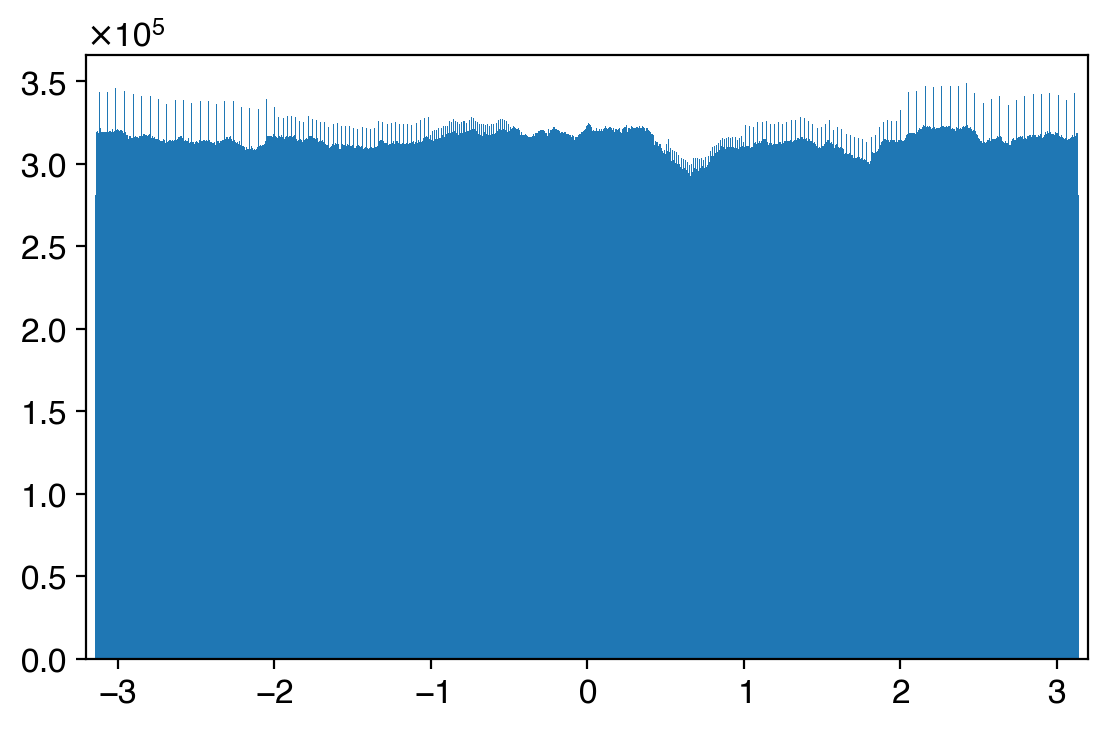

In [337]:
# counts, edges = da.histogram(tdf["Muon_pt"],bins=np.linspace(0,150,100))
counts, edges = da.histogram(tdf["Muon_phi"],bins=np.linspace(-3.2,3.2,1000))
print(len(tdf))
h = Hist1D.from_bincounts(counts.compute(), edges)
print(h.integral)
h.plot()